In [2]:
"""
读取预处理后的aoi数据
手工标注校准数据, 形成最终结果
如电梯楼/楼梯楼, 楼层数, 名称, aoi数据中缺失的楼等
"""
import json
import pickle
import folium
import shapely
from shapely import ops
from pyproj import Proj
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint, MultiPolygon, Point
from eviltransform import gcj2wgs, bd2wgs, bd2gcj, wgs2gcj
projector = Proj("+proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
regions = pickle.load(open("data/regions_all.pkl", "rb"))
buildings = pickle.load(open("data/buildings_all.pkl", "rb"))

buildings = {bd["id"]:bd for bd in buildings if bd["task_id"] == "复旦"}
print("orig buildings:", len(buildings))

orig buildings: 241


In [14]:
buildings_processed = [
    {"id": 750, "is_elevator": True, "floor": 14},
    {"id": 757, "is_elevator": True, "floor": 12},
    {"id": 755, "is_elevator": False, "floor": 5},
    {"id": 754, "is_elevator": False, "floor": 5},  # 在小区外
    {"id": (752, 742), "is_elevator": False, "floor": 5, "name": "和平街十二区-11号楼"},
    {"id": 753, "is_elevator": False, "floor": 4},
    {"id": 745, "is_elevator": False, "floor": 4},
    {"id": 735, "is_elevator": False, "floor": 4},
    {"id": 736, "is_elevator": False, "floor": 5},
    {"id": 726, "is_elevator": False, "floor": 4},
    {"id": 730, "is_elevator": False, "floor": 5},  # 被围起来了, 似乎找不到进去的路
    {"id": 713, "is_elevator": False, "floor": 7},
    {"id": 721, "is_elevator": False, "floor": 4, "name": '和平街十二区-15号楼'},
    {"id": 711, "is_elevator": False, "floor": 4},
    {"id": 715, "is_elevator": False, "floor": 3},
    {"id": 710, "is_elevator": False, "floor": 4},
    {"id": 716, "is_elevator": False, "floor": 5},
    {"id": 705, "is_elevator": False, "floor": 4},
    {"id": 175, "is_elevator": False, "floor": 4},
    {"id": 155, "is_elevator": False, "floor": 5, "name": '和平街十二区甲-1号楼'},
    {"id": 172, "is_elevator": False, "floor": 5, "name": '和平街十二区甲-3号楼'},
    {"id": 162, "is_elevator": False, "floor": 5},
    {"id": 153, "is_elevator": False, "floor": 3, "name": '和平街十二区-1号楼'},
    {"id": 154, "is_elevator": False, "floor": 6},
    {"id": 161, "is_elevator": True, "floor": 13},
    {"id": 158, "is_elevator": False, "floor": 6},
    {"id": 165, "is_elevator": True, "floor": 13},
    {"id": 749, "is_elevator": False, "name": '和平街十五区2号院甲1号楼'},
    {"id": 740, "is_elevator": True, "name": '和平街十五区2号院2号楼'},
    {"id": 739, "is_elevator": True, "name": '和平街十五区2号院1号楼'},
    {"id": 128, "is_elevator": False, "floor": 4},
    {"id": 143, "is_elevator": False, "floor": 5},
    {"id": 104, "is_elevator": False, "floor": 4},
    {"id": 100, "is_elevator": False, "floor": 4},
    {"id": 109, "is_elevator": False, "floor": 4},
    {"id": 99, "is_elevator": False, "floor": 4},
    {"id": 103, "is_elevator": False, "floor": 4},
    {"id": (108, 95, 98), "is_elevator": False, "name": "和平街十三区-27号楼"},
    {"id": 707, "is_elevator": True, "name": "和平街十五区1号楼"},
    {"id": 177, "is_elevator": True},
    {"id": 167, "is_elevator": True},
    {"id": 156, "is_elevator": True},
    {"id": 144, "is_elevator": True},
    {"id": 132, "is_elevator": True},
    {"id": 181, "is_elevator": False},
    {"id": 147, "is_elevator": False},
    {"id": (124, 127), "is_elevator": False, "name": "和平街十五区13号楼"},
    {"id": 101, "is_elevator": True},
    {"id": 102, "is_elevator": True},
    {"id": 83, "is_elevator": True},
    {"id": 84, "is_elevator": False},
    {"id": 74, "is_elevator": False},
    {"id": 62, "is_elevator": False},
    {"id": 70, "is_elevator": False},
    {"id": 17, "is_elevator": False},
    {"id": 27, "is_elevator": False},
    {"id": 9, "is_elevator": False},
    {"id": 2, "is_elevator": False},
    {"id": 434, "is_elevator": False},
    {"id": 391, "is_elevator": False},
    {"id": 85, "is_elevator": False},
    {"id": 79, "is_elevator": False},
    {"id": 80, "is_elevator": False},
    {"id": 50, "is_elevator": True},
    {"id": 53, "is_elevator": True},
    {"id": 52, "is_elevator": True},
    {"id": (71, 67), "is_elevator": True, "name": "和平街十三区-35号楼"},
    {"id": 51, "is_elevator": True},
    {"id": 69, "is_elevator": True},
    {"id": 57, "is_elevator": False},
    {"id": 60, "is_elevator": False},
    {"id": 48, "is_elevator": False},
    {"id": 76, "is_elevator": True},
    {"id": 87, "is_elevator": True},
    {"id": 78, "is_elevator": False, "name": "煤炭科学研究总院1号楼"},
    {"id": (107,118,116), "is_elevator": False, "name": "煤炭科学研究总院3号楼"},  # 把几个AOI合并
    {"id": (126,129,130), "is_elevator": False, "name": "煤炭科学研究总院4号楼"},
    {"id": (113,114), "is_elevator": False, "name": "煤炭科学研究总院5号楼"},
    {"id": 123, "is_elevator": False, "name": "煤炭科学研究总院7号楼"},
    {"id": 89, "is_elevator": False, "name": "安科大厦"},
    {"id": 46, "is_elevator": False},
    {"id": 40, "is_elevator": False},
    {"id": 39, "is_elevator": False},
    {"id": 33, "is_elevator": False, "name": "华表大厦"},
    {"id": 42, "is_elevator": False},
    {"id": 25, "is_elevator": False},
    {"id": 10, "is_elevator": False},
    {"id": 432, "is_elevator": False},
    {"id": 418, "is_elevator": False, "name": "和平街十四区社区9号楼"},
    {"id": 399, "is_elevator": False},
    {"id": 404, "is_elevator": False},
    {"id": 397, "is_elevator": False},
    {"id": 19, "is_elevator": False},
    {"id": 429, "is_elevator": False},
    {"id": 415, "is_elevator": True, "name": "和平街十四区甲15号楼"},
    {"id": 406, "is_elevator": True, "name": "和平街十四区社区南院-甲15号楼"},
    {"id": 416, "is_elevator": False},
    {"id": 55, "is_elevator": False},
    {"id": 413, "is_elevator": False},
    {"id": 6, "is_elevator": False},
    {"id": 438, "is_elevator": False},
    {"id": 396, "is_elevator": False},
    {"id": 403, "is_elevator": False},
]
print("buildings processed:", len(buildings_processed))

buildings processed: 103


In [15]:
# 手动添加一些building(原始数据里也没有的)(本质是校区/院区)
buildings_add = [
    {
        'gate_gps': (116.426208,39.966316),
        'id': 10000,
        'name': '朝阳区师范学校附属小学和平街分校北校区',
        'points': [
            (116.425865,39.966304),
            (116.426519,39.96632),
            (116.426659,39.966176),
            (116.42668,39.965556),
            (116.425902,39.965556),
            (116.425865,39.966304)
        ],
        'is_elevator': False,
        'floor': 1
    },
    {
        'gate_gps': (116.42595,39.96482),
        'id': 10001,
        'name': '北京精诚实验小学',
        'points': [
            (116.425956,39.964844),
            (116.426669,39.964857),
            (116.426691,39.964203),
            (116.425977,39.964203),
            (116.425956,39.964844)
        ],
        'is_elevator': False,
        'floor': 1
    },
    {
        'gate_gps': (116.428922,39.96891),
        'id': 10002,
        'name': '中国石化北京化工研究院',
        'points': [
            (116.426519,39.968627),
            (116.428965,39.968688),
            (116.428922,39.96891),
            (116.430011,39.968906),
            (116.430124,39.966514),
            (116.426535,39.966452),
            (116.426519,39.968627)
        ],
        'is_elevator': False,
        'floor': 1
    },
    {
        'gate_gps': (116.427539,39.965118),
        'id': 10003,
        'name': '北京市朝阳区烟草专卖局',
        'points': [
            (116.427223,39.965134),
            (116.427732,39.965139),
            (116.427732,39.96499),
            (116.427233,39.964986),
            (116.427223,39.965134),
        ],
        'is_elevator': False,
        'floor': 1
    },
    {
        'gate_gps': (116.426327,39.965291),
        'id': 10004,
        'name': '北京精诚文化学校',
        'points': [
            (116.425978,39.965402),
            (116.426665,39.965406),
            (116.42667,39.965262),
            (116.425983,39.965262),
            (116.425978,39.965402),
        ],
        'is_elevator': False,
        'floor': 1
    },
]
for b in buildings_add:
    b["points"] = [gcj2wgs(*p[::-1])[::-1] for p in b["points"]]
    b["gate_gps"] = gcj2wgs(*b["gate_gps"][::-1])[::-1]
    b["gate_xy"] = projector(*b["gate_gps"])
    b["gate_id"] = str(b["id"])
    buildings[b["id"]] = b
buildings_processed += buildings_add
print("buildings processed:", len(buildings_processed))

buildings processed: 108


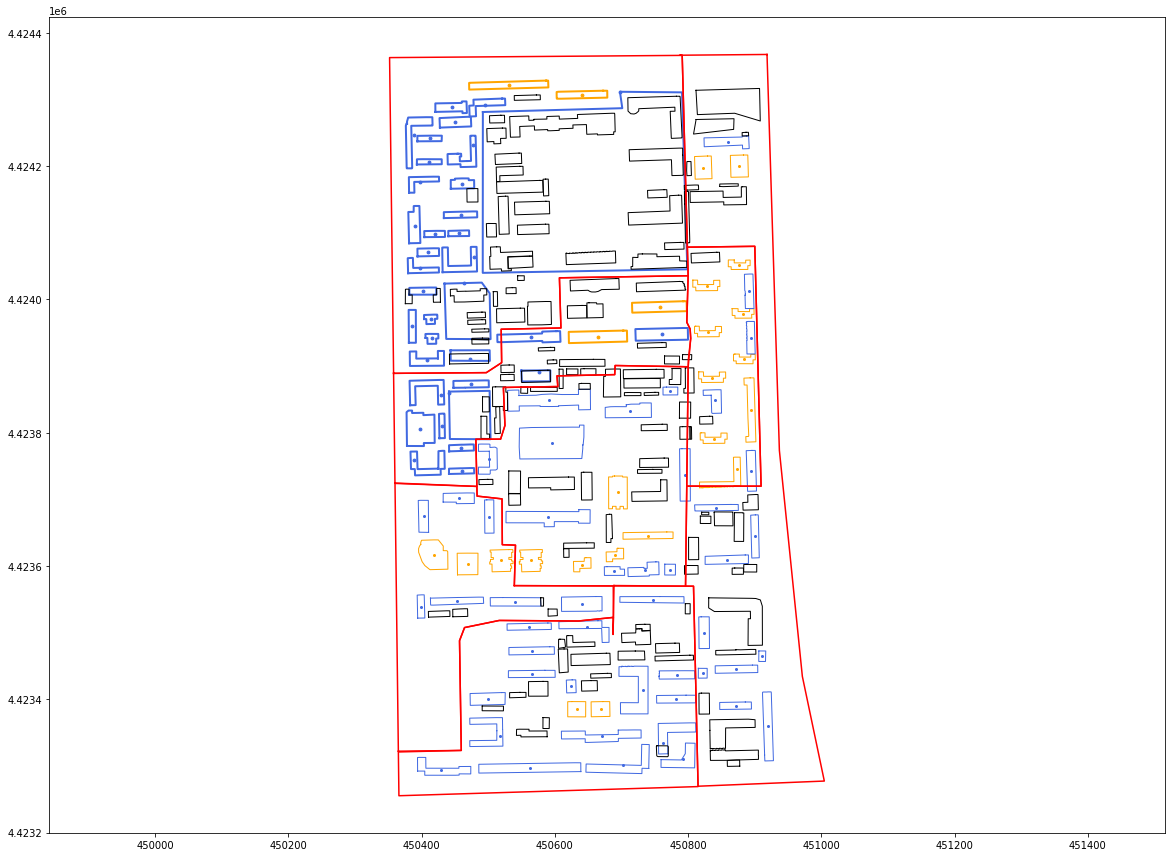

In [16]:
plt.figure(figsize=(20, 15))
plt.axis("equal")
tmp = []
processed_ids = []
for x in buildings_processed:
    color = "orange" if x["is_elevator"] else "royalblue"
    s = 2 if "floor" in x else 1
    if isinstance(x["id"], int):
        processed_ids.append(x["id"])
        bd = buildings[x["id"]]
        xys = [projector(*p) for p in bd["points"]]
        plt.plot(*zip(*xys), c=color, linewidth=s)
        plt.scatter(*bd["gate_xy"], c=color, s=s*4)
        tmp.append(Polygon(xys))
    else:
        processed_ids += list(x["id"])
        polys = [Polygon([projector(*p) for p in buildings[y]["points"]]) for y in x["id"]]
        convex_hull = MultiPoint(sum([poly.exterior.coords[:] for poly in polys], [])).convex_hull
        polys_scale = [shapely.affinity.scale(p, xfact=1.1, yfact=1.1, origin='centroid') for p in polys]
        poly_scale = shapely.ops.unary_union(polys_scale)
        poly_final:Polygon = poly_scale.intersection(convex_hull)
        xys = poly_final.exterior.coords[:]
        gate_xy = poly_final.centroid
        if not poly_final.within(poly_final):
            gate_xy = poly_final.representative_point()
        gate_xy = gate_xy.coords[:][0]
        plt.plot(*zip(*xys), c=color, linewidth=s)
        plt.scatter(*gate_xy, c=color, s=s*4)
        tmp.append(poly_final)
processed_ids = set(processed_ids)
for bid, bd in buildings.items():
    if bid not in processed_ids:
        xys = [projector(*p) for p in bd["points"]]
        plt.plot(*zip(*xys), c="black", linewidth=1)
        # plt.scatter(*bd["gate_xy"], c="black")
for region in regions:
    xys = [projector(*p) for p in region["boundary"]]
    for p in tmp:
        if Polygon(xys).intersects(p):
            plt.plot(*zip(*xys), c="red")
            break

In [17]:
# 形成校正后的结果
buildings_output = []
for x in buildings_processed:
    if isinstance(x["id"], int):
        bd = buildings[x["id"]]
        bd.pop("task_id", None)
        for k, v in x.items():
            bd[k] = v
        buildings_output.append(bd)
    else:
        polys = [Polygon([projector(*p) for p in buildings[y]["points"]]) for y in x["id"]]
        convex_hull = MultiPoint(sum([poly.exterior.coords[:] for poly in polys], [])).convex_hull
        polys_scale = [shapely.affinity.scale(p, xfact=1.1, yfact=1.1, origin='centroid') for p in polys]
        poly_scale = shapely.ops.unary_union(polys_scale)
        poly_final:Polygon = poly_scale.intersection(convex_hull)
        xys = poly_final.exterior.coords[:]
        gate_xy = poly_final.centroid
        if not gate_xy.within(poly_final):
            gate_xy = poly_final.representative_point()
        gate_xy = gate_xy.coords[:][0]
        buildings_output.append({
            "id": x["id"][0],
            "name": x["name"],
            "points": [projector(*p, inverse=True) for p in xys],
            "is_elevator": x["is_elevator"],
            "gate_gps": projector(*gate_xy, inverse=True),
            "gate_xy": gate_xy,
            "gate_id": str(x["id"][0]),
        })
        if "floor" in x:
            buildings_output[-1]["floor"] = x["floor"]
print("buildings_output:", len(buildings_output))
for x in buildings_output:
    assert len(x) == 7 or len(x) == 8 and "floor" in x
pickle.dump(buildings_output, open("data/buildings_fudan_new.pkl", "wb"))

buildings_output: 108


In [18]:
# 合并三个人标的楼
buildings_fudan = pickle.load(open("data/buildings_fudan_new.pkl", "rb"))
print("buildings_fudan:", len(buildings_fudan))

buildings_jinhui = pickle.load(open("data/buildings_jinhui.pkl", "rb"))
print("buildings_jinhui:", len(buildings_jinhui))

buildings_jinwei = pickle.load(open("data/buildings_jinwei.pkl", "rb"))
for x in buildings_jinwei:
    x.pop("task_id", None)
buildings_jinwei.append({
    'id': 233, 
    'points': [(116.42045031542834, 39.95475697976013), (116.42099510851567, 39.954751572879644), (116.42098718116858, 39.95408959018193), (116.42103024447712, 39.95408963758539), (116.42102725791042, 39.95394963979848), (116.42046043213064, 39.95395502217913), (116.42046341834647, 39.95409701981258), (116.4207828817073, 39.95409336624), (116.42079082860131, 39.954601354941296), (116.42044733049059, 39.95460498252283), (116.42045031542834, 39.95475697976013)],
    'gate_gps': (116.42079332883596, 39.95435226908862),
    'gate_xy': (450526.0371108048, 4422851.377868257),
    'gate_id': '233',
    'name': '国家林业和草原局',
    'is_elevator': True
})
print("buildings_jinwei:", len(buildings_jinwei))

buildings = buildings_fudan + buildings_jinhui + buildings_jinwei
key_set1 = {"id", "name", "is_elevator", "points", "gate_id", "gate_gps", "gate_xy"}
key_set2 = {"id", "name", "is_elevator", "points", "gate_id", "gate_gps", "gate_xy", "floor"}
bid_set = []
for b in buildings:
    assert str(b["id"]) == b["gate_id"]
    assert set(b.keys()) == key_set1 or set(b.keys()) == key_set2
    bid_set.append(b["id"])
assert len(buildings) == len(set(bid_set))
print("all buildings:", len(buildings))

# 找出楼所在的路区
for r in regions:
    r["poly"] = Polygon(r["boundary"])
for bd in buildings:
    p = Point(bd["gate_gps"])
    dis_ids = []
    for r in regions:
        dis = p.distance(r["poly"])
        if dis == 0:
            bd["region"] = r["id"]
            break
        dis_ids.append((dis, r["id"]))
    else:
        bd["region"] = min(dis_ids, key=lambda x:x[0])[1]

pickle.dump(buildings, open("data/buildings_new.pkl", "wb"))

buildings_fudan: 108
buildings_jinhui: 162
buildings_jinwei: 240
all buildings: 510


In [88]:
# 可视化
buildings = pickle.load(open("data/buildings_new.pkl", "rb"))
G_folium = folium.Map(
    location=[39.967691, 116.426234],
    control_scale=True,
    tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=8&x={x}&y={y}&z={z}',
    attr='高德底图',
    zoom_start=20,
)
for bd in buildings:
    color = "orange" if bd["is_elevator"] else "royalblue"
    folium.PolyLine(
        locations=[wgs2gcj(*p[::-1]) for p in bd["points"]],
        opacity=0.8,
        weight=3,
        popup=(bd["id"], bd["name"], bd["region"]),
        color=color
    ).add_to(G_folium)
    folium.CircleMarker(
        location=wgs2gcj(*bd["gate_gps"][::-1]),
        opacity=0.8,
        radius=2,
        fill=True,   
        popup=(bd["gate_id"], bd["name"]),
        color=color
    ).add_to(G_folium)
for r in regions:
    folium.PolyLine(
        locations=[wgs2gcj(*p[::-1]) for p in r["boundary"]],
        opacity=0.8,
        weight=2,
        popup=r["id"],
        color="red",
    ).add_to(G_folium)
G_folium.save("figure/buildings_new.html")

In [3]:
def get_geojson(buildings):
    bd_geojson = []
    for bd in buildings:
        bd_geojson.append(
            {
                "type": "Feature",
                "properties": {k: bd[k] for k in ["id", "name", "is_elevator", "floor"] if k in bd},
                "geometry": {"type": "Polygon", "coordinates": [bd["points"]]},
            }
        )
    return bd_geojson

buildings = pickle.load(open("data/buildings_new.pkl", "rb"))
t = get_geojson(buildings)
json.dump(t, open("data/buildings_geojson_new.json", "w"))


In [20]:
# 筛选3D两个路区的楼, 生成geojson
polys = [Polygon(r["boundary"]) for r in regions if r["id"] == 107 or r["id"] == 11]
buildings = pickle.load(open("data/buildings_new.pkl", "rb"))
buildings = [x for x in buildings if Point(x["gate_gps"]).within(polys[0]) or Point(x["gate_gps"]).within(polys[1])]
t = get_geojson(buildings)
for x in t:
    for k in ["id", "name", "is_elevator", "floor"]:
        assert k in x["properties"], (k, x["properties"]["id"], x["properties"]["name"])
json.dump(t, open("data/buildings_geojson_new_part.json", "w"))